In [2]:
# Allow importing from the code directory.
import sys
sys.path.append('../code/')

In [3]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt

from matplotlib.colors import to_rgba

from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.metrics import classification_report, confusion_matrix
from etch import load_census, create_census_pipeline, SelectFromCollection

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [4]:
from IPython.display import display, clear_output
import ipywidgets as widgets

%matplotlib widget

In [5]:
census = load_census(codes=True)

In [6]:
model = RandomForestClassifier(random_state=42)

# This doesn't converge for some reason.
# model = LogisticRegression(max_iter=500, random_state=42)
# transformer = None
transformer = TargetEncoder()
pipeline = create_census_pipeline(model, transformer=transformer)

In [7]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(census.y_train)
y_test_encoded = encoder.transform(census.y_test)


In [8]:
pipeline.fit(census.X_train, y_train_encoded)

Pipeline(steps=[('preprocessor', TargetEncoder()),
                ('estimator', RandomForestClassifier(random_state=42))])

In [9]:
y_test_probabilities = pipeline.predict_proba(census.X_test)
y_test_predictions = (y_test_probabilities[:, 1] >= 0.5).astype(int)

print(classification_report(y_test_encoded, y_test_predictions))
print(confusion_matrix(y_test_encoded, y_test_predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     93576
           1       0.77      0.45      0.57      6186

    accuracy                           0.96     99762
   macro avg       0.87      0.72      0.77     99762
weighted avg       0.95      0.96      0.95     99762

[[92740   836]
 [ 3399  2787]]


In [10]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(pd.DataFrame(pipeline.named_steps["preprocessor"].transform(census.X_test), columns=pipeline.named_steps["preprocessor"].get_feature_names_out()))


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


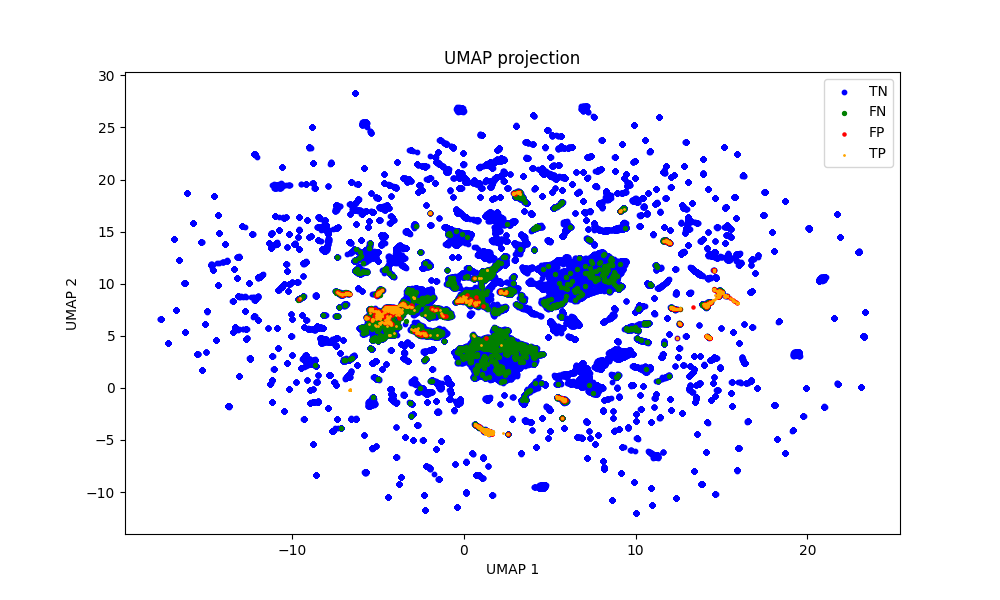

In [11]:
plt.figure(figsize=(10, 6))

TN = (y_test_encoded == 0) & (y_test_predictions == 0)
plt.scatter(X_umap[TN, 0], X_umap[TN, 1], color='blue', label='TN', s=10)

FN = (y_test_encoded == 1) & (y_test_predictions == 0)
plt.scatter(X_umap[FN, 0], X_umap[FN, 1], color='green', label='FN', s=8)

FP = (y_test_encoded == 0) & (y_test_predictions == 1)
plt.scatter(X_umap[FP, 0], X_umap[FP, 1], color='red', label='FP', s=5)

TP = (y_test_encoded == 1) & (y_test_predictions == 1)
plt.scatter(X_umap[TP, 0], X_umap[TP, 1], color='orange', label='TP', s=1)

plt.title('UMAP projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.savefig('../results/umap.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:
# LOL why did I even make this?

# try:
#     plt.close(fig)
# except:
#     pass

# df = census.X_test.copy()
# df.loc[:, ["UMAP1", "UMAP2"]] = X_umap
# df.loc[(y_test_encoded == 0) & (y_test_predictions == 0), "Label"] = "TN"
# df.loc[(y_test_encoded == 1) & (y_test_predictions == 0), "Label"] = "FN"
# df.loc[(y_test_encoded == 1) & (y_test_predictions == 1), "Label"] = "TP"
# df.loc[(y_test_encoded == 0) & (y_test_predictions == 1), "Label"] = "FP"

# df_fp = df[df['Label'] == 'FP']

# default_max_columns = pd.get_option('display.max_columns')
# pd.set_option('display.max_columns', None)

# output = widgets.Output()

# def frame(ind):
#     with output:
#         clear_output(wait=True)
#         display(df_fn.iloc[ind])

# fig, ax = plt.subplots(figsize=(10, 6))

# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# rgba_colors = [to_rgba(color) for color in default_colors]

# collection = ax.scatter(df_fp['UMAP1'], df_fp['UMAP2'])
# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')

# selector = SelectFromCollection(ax, collection, onscreen=frame)

# display(output)
